# Portfolio Optimization and Backtesting With Python

Written by Nathan Ramos, CFA${^®}$, of NR Capital Management, LLC.

Schedule a [FREE consultation](https://calendly.com/nrcapitalmanagement/30min) to see how we can enhance your investment strategy with statistical methods such as what you see below.

## Introduction

**Run this notebook by clicking "Runtime" in the top menu, then click "Run all", or press CTRL + F9.**

 Portfolio optimization is a quantitative process used to select an optimal set of assets from a larger pool to achieve specific investment objectives. The aim is to construct a portfolio that offers the maximum possible expected return for a given level of risk, or equivalently, to minimize risk for a given level of expected return. Traditional methods often rely on Markowitz’s Efficient Frontier, which models the trade-off between risk and return for a set of risky assets. The optimization problem involves input parameters like expected returns, variances, and covariances for the assets under consideration. Constraints may also be added to tailor the optimization to an investor's particular needs. By employing mathematical models and techniques, portfolio optimization helps investors make informed decisions, providing a data-driven foundation for selecting and allocating assets in an investment portfolio. However, these models should be used with caution and be used as a guideline rather than a definitive answer and is best employed in conjunction with other tools and analyses. No model is perfect and the true optimal portfolio may differ from the one computed by a portfolio optimization algorithm.

## Install Libraries

Before we dive into the code, we need to install the libraries that will be utilized throughout this notebook. Running the following cell will install the necessary Python packages:

In [1]:
# %%capture
# !pip install PyPortfolioOpt yahooquery bt ffn

- PyPortfolioOpt: For portfolio optimization algorithms and utility functions.
- yahooquery: To fetch financial data from Yahoo Finance.
- bt: For backtesting portfolio strategies.
- ffn: A financial function library for working with financial data.

Simply run the cell to install these packages. The %%capture magic command will suppress any output, ensuring a clean notebook.

## Import Libraries

Once the packages are installed, we need to import them to start using their features. Run the following cell to import the libraries:

In [2]:
import sys
sys.path.append("../")

from portopt import data
from portopt import utils
from portopt import plotting
from portopt import semivariance as algo
from portopt import backtesting as bkt
import pandas as pd

In [3]:
portfolio_tickers = [
    'SPY', # Stocks
    'BND', # Bonds
    'GLD', # Gold
    'GBTC', # Crypto
    'BTAL' # Anti-Beta
]

In [4]:
weight_bounds = [
    (0, 1.0), # SPY 0-100%
    (0, 1.0), # BND 0-100%
    (0, 0.1), # GLD 0-10%
    (0, 0.05), # GBTC 0-5%
    (0, 0.05) # BTAL 0-5%
]

In [5]:
investor_views = {
    'SPY': 0.0044, # investor expects 0.44% return
    'BND': 0.0500 # investor expects 5.00% return
}

In [6]:
view_confidences = pd.Series({
    'SPY': 0.4415, # investor is 44.15% confident in view
    'BND': 0.5000 # investor is 50.00% confident in view
})

In [7]:
n_portfolios = 1000 
nsim = 1000

In [8]:
historical_prices = data.get_historical_prices(portfolio_tickers)
summary_detail = data.get_summary_details(portfolio_tickers)
risk_free_rate, risk_free_rate_name = data.get_risk_free_rate()
historical_risk_free_rate, risk_free_rate_name = data.get_historical_risk_free_rate()
weight_bounds = data.get_weight_bounds(portfolio_tickers, weight_bounds)

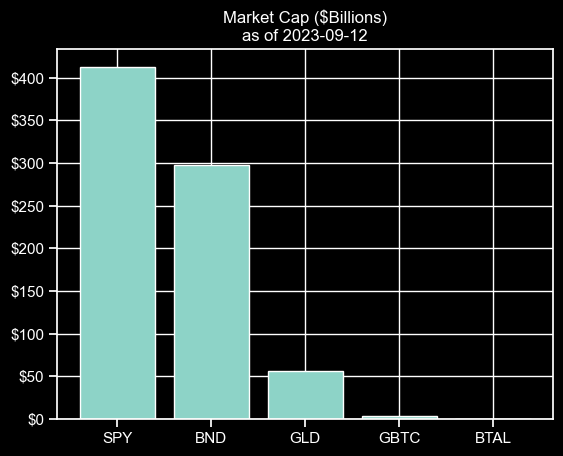

In [9]:
market_caps = data.get_market_caps(summary_detail)
plotting.plot_market_caps(market_caps, historical_prices)

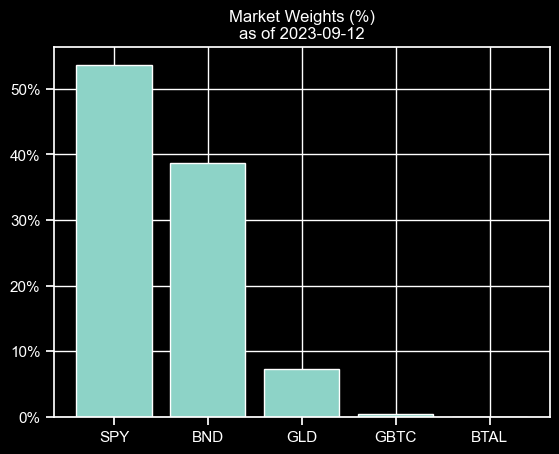

In [10]:
market_cap_weights = data.get_market_cap_weights(market_caps)
plotting.plot_market_weights(market_cap_weights, historical_prices)

In [11]:
benchmark_name = 'Market Cap Weighted Portfolio'
benchmark_portfolio = data.get_benchmark_portfolio(market_cap_weights.to_dict())
benchmark_prices = data.get_historical_prices(benchmark_portfolio.keys())

In [12]:
import pandas as pd
pd.DataFrame.from_dict(benchmark_portfolio, orient='index', columns=[benchmark_name]).squeeze().sort_values(ascending=False)

SPY     0.5367
BND     0.3863
GLD     0.0722
GBTC    0.0044
BTAL    0.0003
Name: Market Cap Weighted Portfolio, dtype: float64

In [13]:
historical_prices, benchmark_prices, historical_risk_free_rate = data.get_historical_data(
    historical_prices, benchmark_prices, historical_risk_free_rate
)

In [14]:
average_historical_return = data.get_average_historical_return(historical_prices)
average_historical_return

symbol
BND     0.0114
BTAL   -0.0038
GBTC    0.7159
GLD     0.0717
SPY     0.1487
dtype: float64

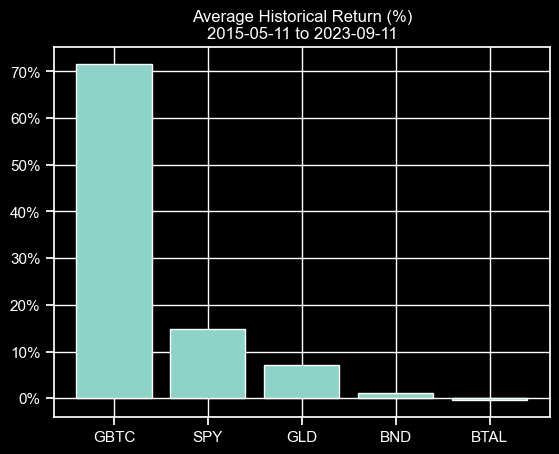

In [15]:
plotting.plot_average_return(average_historical_return, historical_prices)

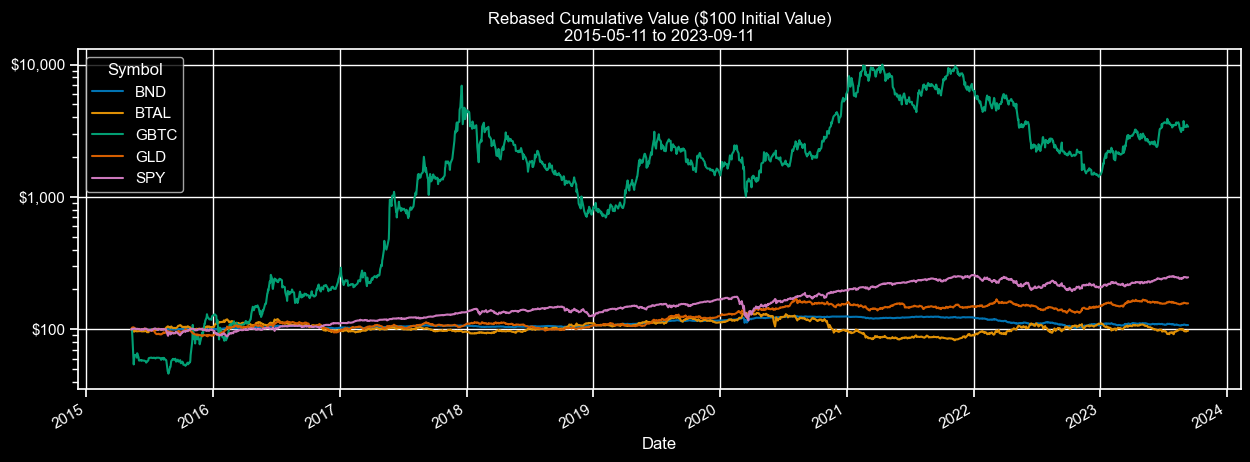

In [16]:
plotting.plot_rebased_cumulative_value(historical_prices, logy=True)

In [17]:
average_risk_free_rate = data.get_average_risk_free_rate(historical_risk_free_rate)

In [18]:
current_prices = data.get_current_prices(portfolio_tickers+list(benchmark_portfolio.keys()))

In [19]:
names = data.get_names(current_prices)

In [20]:
market_prices = data.get_market_prices(historical_prices, market_cap_weights)

In [21]:
covariance_matrix = algo.get_covariance_matrix(historical_prices, method='oracle_approximating')
covariance_matrix

symbol,BND,BTAL,GBTC,GLD,SPY
symbol,,,,,
BND,0.004395,0.000307,0.004463,0.003856,0.000612
BTAL,0.000307,0.035250,-0.030357,0.003117,-0.019495
GBTC,0.004463,-0.030357,1.112124,0.018414,0.055897
GLD,0.003856,0.003117,0.018414,0.026675,0.001250
SPY,0.000612,-0.019495,0.055897,0.001250,0.041532


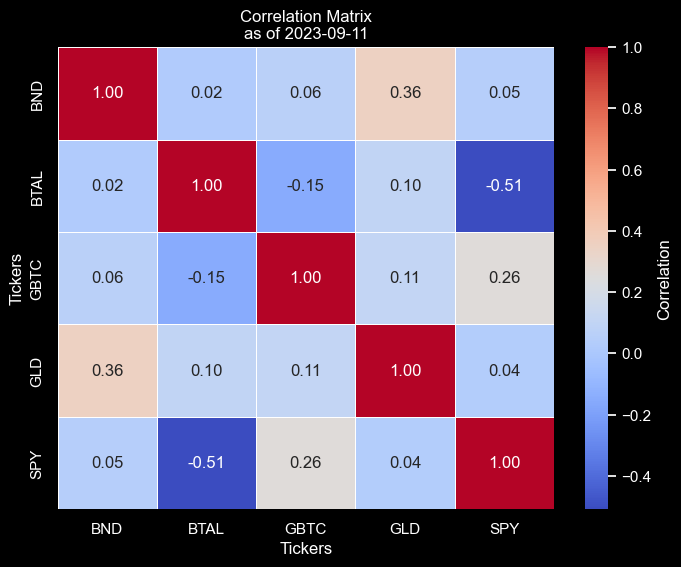

In [22]:
plotting.plot_correlation_matrix(covariance_matrix, historical_prices)

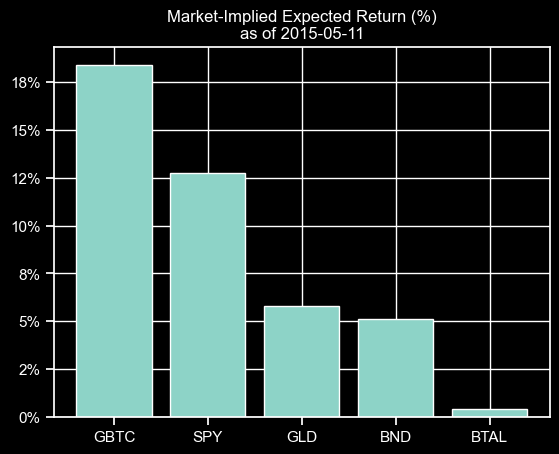

In [23]:
market_risk_aversion, market_implied_expected_returns = algo.get_market_implied_metrics(
    market_prices,
    market_caps,
    covariance_matrix,
    risk_free_rate
)
plotting.plot_market_implied_expected_returns(market_implied_expected_returns, historical_prices)

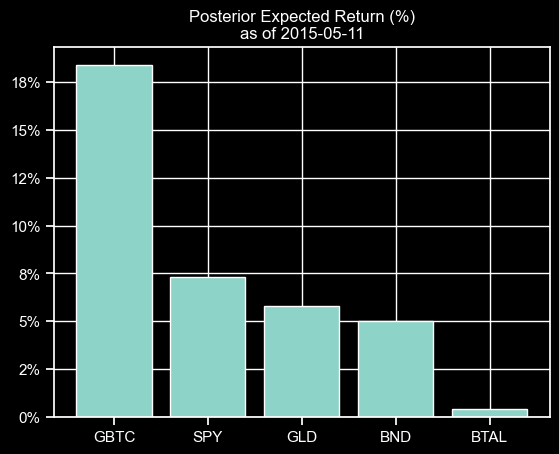

In [24]:
posterior_covariance_matrix, posterior_expected_returns = algo.get_black_litterman_params(
    covariance_matrix,
    portfolio_tickers,
    investor_views,
    market_risk_aversion,
    market_caps,
    risk_free_rate,
    view_confidences,
    market_implied_expected_returns
)
plotting.plot_posterior_expected_returns(posterior_expected_returns, historical_prices)

In [25]:
min_risk, min_risk_weights = algo.get_min_risk_portfolio(
    posterior_expected_returns,
    historical_prices,
    weight_bounds,
    risk_free_rate
)

In [26]:
max_risk = algo.get_max_risk(
    posterior_expected_returns,
    historical_prices,
    weight_bounds,
    risk_free_rate,
    min_risk
)

10it [00:01,  7.72it/s]


In [27]:
performance_df_optimal, weights_df_optimal = algo.optimize_portfolio(
    posterior_expected_returns,
    historical_prices,
    weight_bounds,
    risk_free_rate
)

10it [00:01,  7.53it/s]
1it [00:00,  3.11it/s]C:\Users\25del\anaconda3\envs\nrcapital\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
99it [00:20,  4.79it/s]


In [28]:
performance_df_optimal

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Expected annual return,0.0494,0.0506,0.0518,0.0528,0.0536,0.0545,0.0552,0.0558,0.0564,0.0569,...,0.0777,0.0779,0.0780,0.0781,0.0782,0.0784,0.0785,0.0786,0.0787,0.0788
Annual semi-deviation,0.0421,0.0427,0.0439,0.0449,0.0461,0.0472,0.0484,0.0495,0.0507,0.0518,...,0.1443,0.1454,0.1465,0.1477,0.1488,0.1500,0.1511,0.1522,0.1534,0.1545
Sortino ratio,0.1636,0.1906,0.2130,0.2284,0.2419,0.2532,0.2619,0.2688,0.2742,0.2785,...,0.2442,0.2431,0.2421,0.2411,0.2401,0.2391,0.2381,0.2372,0.2362,0.2353


In [29]:
algo.get_ef_portfolios(names, weights_df_optimal)

,shortName,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
BND,Vanguard Total Bond Market ETF,0.8855,0.8279,0.8079,0.8167,0.8248,0.8244,0.8030,0.7837,0.7665,...,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.00
BTAL,AGF U.S. Market Neutral Anti-Be,0.0500,0.0500,0.0417,0.0257,0.0105,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.00
GBTC,GRAYSCALE BITCOIN TRUST BTC,0.0000,0.0018,0.0055,0.0068,0.0080,0.0098,0.0130,0.0159,0.0186,...,0.0500,0.050,0.0500,0.0500,0.0500,0.0500,0.050,0.0500,0.0500,0.05
GLD,SPDR Gold Trust,0.0000,0.0195,0.0349,0.0425,0.0498,0.0576,0.0673,0.0758,0.0831,...,0.0737,0.065,0.0571,0.0487,0.0402,0.0319,0.024,0.0158,0.0079,0.00
SPY,SPDR S&P 500,0.0645,0.1008,0.1099,0.1084,0.1070,0.1082,0.1167,0.1246,0.1318,...,0.8763,0.885,0.8929,0.9013,0.9098,0.9181,0.926,0.9342,0.9421,0.95


In [30]:
optimal_portfolio_index, optimal_portfolio_details, optimal_weights = algo.get_optimal_portfolio(
    performance_df_optimal,
    weights_df_optimal,
    print_output=True
)

The optimal portfolio is Portfolio 26 with the following details:
Expected annual return    0.0634
Annual semi-deviation     0.0701
Sortino ratio             0.2980
Name: 26, dtype: float64


The optimal weights in Portfolio 26: 
symbol
BND     0.6035
BTAL    0.0000
GBTC    0.0500
GLD     0.1000
SPY     0.2465
Name: 26, dtype: float64


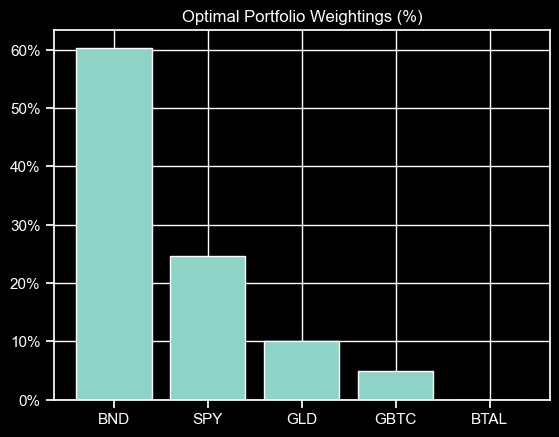

In [31]:
# from typing import Any
# from matplotlib.ticker import FuncFormatter
# import seaborn as sns
# import matplotlib.pyplot as plt

# def format_with_percent(x: Any, pos: Any) -> str:
#     """
#     Formats a number as a percentage string.

#     Parameters:
#     - x (Any): The number to be formatted.
#     - pos (Any): The position (unused, but required by FuncFormatter).

#     Returns:
#     - str: The formatted percentage string.
#     """
#     return '{:,.0%}'.format(x)

# def plot_optimal_portfolio(
#         optimal_weights: pd.Series,
#         color_palette: str = 'colorblind',
#         **kwargs) -> None:
#     """
#     Plots the optimal portfolio as a bar chart.

#     Parameters:
#     - optimal_weights (pd.Series): The optimal portfolio weightings.
#     - color_palette (str): The color palette to use for the plot. Defaults to 'colorblind'.

#     Returns:
#     - None
#     """
#     optimal_weights = optimal_weights.sort_values(ascending=False)
#     with plt.style.context('dark_background'):
#         fig, ax = plt.subplots()

#         sns.set_palette(color_palette)
#         ax.bar(list(optimal_weights.index), optimal_weights.to_list(), **kwargs)
#         formatter = FuncFormatter(format_with_percent)
#         ax.yaxis.set_major_formatter(formatter)

#         plt.title('Optimal Portfolio Weightings (%)')

#         plt.grid()
#         plt.show()
        
plotting.plot_optimal_portfolio(
    optimal_weights
)

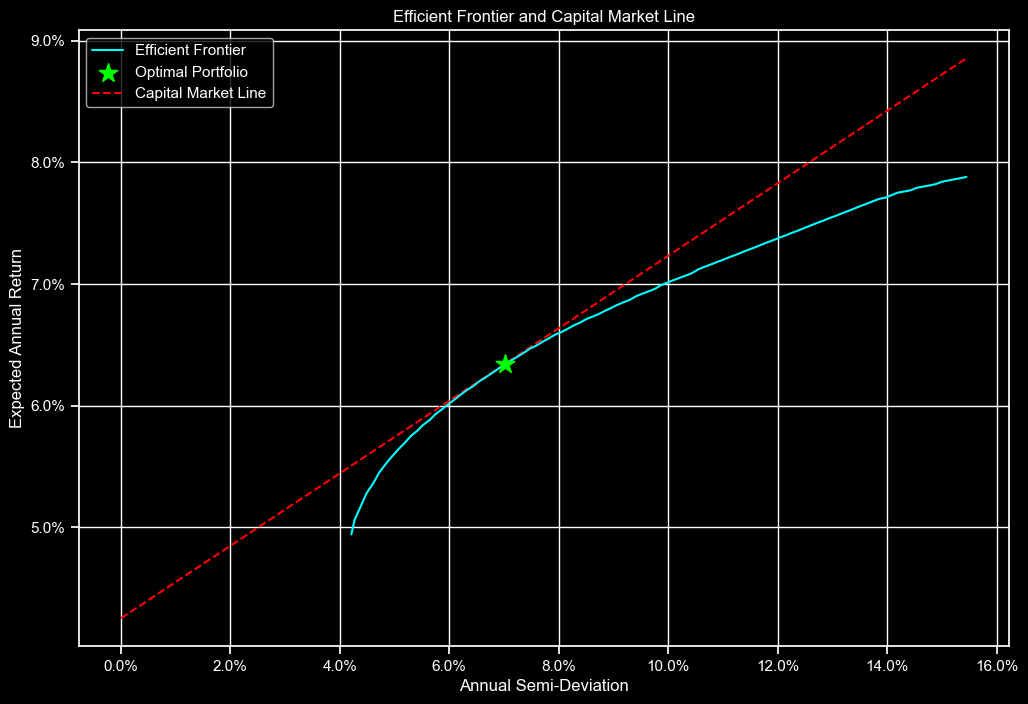

In [32]:
plotting.plot_efficient_frontier(performance_df_optimal, optimal_portfolio_index, risk_free_rate, optimal_color='lime')

In [33]:
weights_df_mc, optimal_portfolio_index_mc, optimal_portfolio_mc, performance_df_mc = algo.generate_optimal_portfolio(
    historical_prices,
    posterior_expected_returns,
    weight_bounds,
    risk_free_rate,
    n_portfolios
)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 404.62it/s]


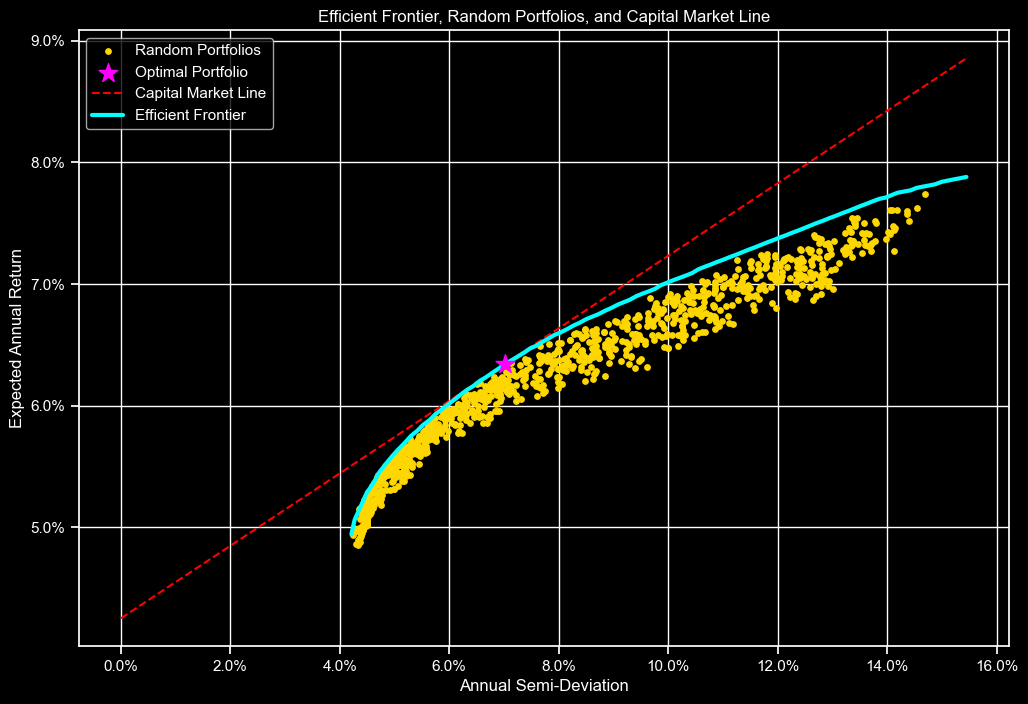

In [34]:
plotting.plot_random_portfolios(
    performance_df_mc,
    optimal_portfolio_details,
    performance_df_optimal,
    risk_free_rate, 
    optimal_color='magenta'
)

In [35]:
strategy_backtest = bkt.optimal_strategy(
    weights_df_optimal,
    optimal_portfolio_index,
    historical_prices,
    strategy_name='Optimal Portfolio'
)

In [36]:
benchmark_backtest = bkt.benchmark_strategy(benchmark_name, benchmark_portfolio, benchmark_prices)

In [37]:
random_strategy = bkt.generate_random_strategy_with_bounds(
        weight_bounds
)

In [38]:
results_with_benchmark_strategy = bkt.run_backtest_with_benchmark(
    strategy_backtest,
    benchmark_backtest,
    average_risk_free_rate
)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]


In [39]:
results_with_random_benchmarks = bkt.run_backtest_with_random_benchmarks(
    strategy_backtest, 
    random_strategy, 
    average_risk_free_rate, 
    nsim
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:12<00:00,  3.20it/s]


In [40]:
bkt.display_results(results_with_benchmark_strategy)

Stat                 Optimal Portfolio    Market Cap Weighted Portfolio
-------------------  -------------------  -------------------------------
Start                2015-05-10           2015-05-10
End                  2023-09-11           2023-09-11
Risk-free rate       2.22%                2.22%

Total Return         105.87%              85.13%
Daily Sharpe         0.93                 0.69
Daily Sortino        1.45                 1.01
CAGR                 9.04%                7.66%
Max Drawdown         -22.05%              -19.81%
Calmar Ratio         0.41                 0.39

MTD                  -0.77%               -0.65%
3m                   1.81%                1.97%
6m                   7.35%                8.82%
YTD                  10.60%               10.38%
1Y                   7.53%                8.19%
3Y (ann.)            2.21%                4.54%
5Y (ann.)            6.72%                7.44%
10Y (ann.)           -                    -
Since Incep. (ann.)  9.04%  

In [41]:
results_with_benchmark_strategy.stats

,Optimal Portfolio,Market Cap Weighted Portfolio
start,2015-05-10 00:00:00,2015-05-10 00:00:00
end,2023-09-11 00:00:00,2023-09-11 00:00:00
rf,0.0222,0.0222
total_return,1.058664,0.85131
cagr,0.090442,0.076648
max_drawdown,-0.220477,-0.198077
calmar,0.410209,0.386962
mtd,-0.007708,-0.006524
three_month,0.018053,0.019714
six_month,0.073481,0.088184


In [42]:
bkt.get_series_from_object(results_with_benchmark_strategy)

,Optimal Portfolio,Market Cap Weighted Portfolio
2015-05-11,100.000000,100.000000
2015-05-12,99.933000,99.853554
2015-05-13,99.993651,99.966703
2015-05-14,100.023159,100.603900
2015-05-15,100.023159,100.603900
...,...,...
2023-09-07,205.933453,184.424482
2023-09-08,205.933453,184.424482
2023-09-09,205.933453,184.424482
2023-09-10,205.933453,184.424482


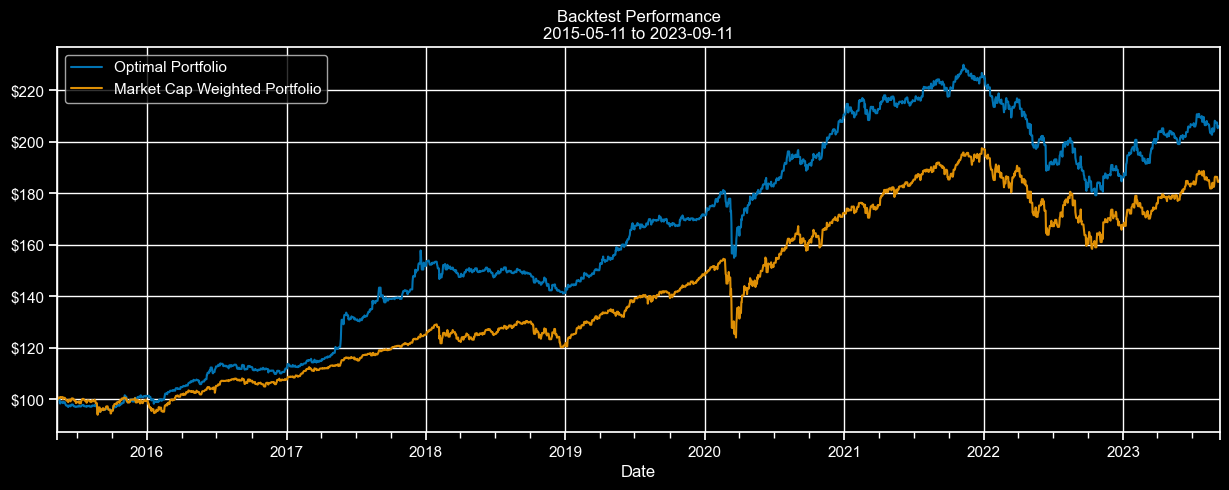

In [43]:
plotting.plot_backtest(results_with_benchmark_strategy, logy=False, title='Backtest Performance')

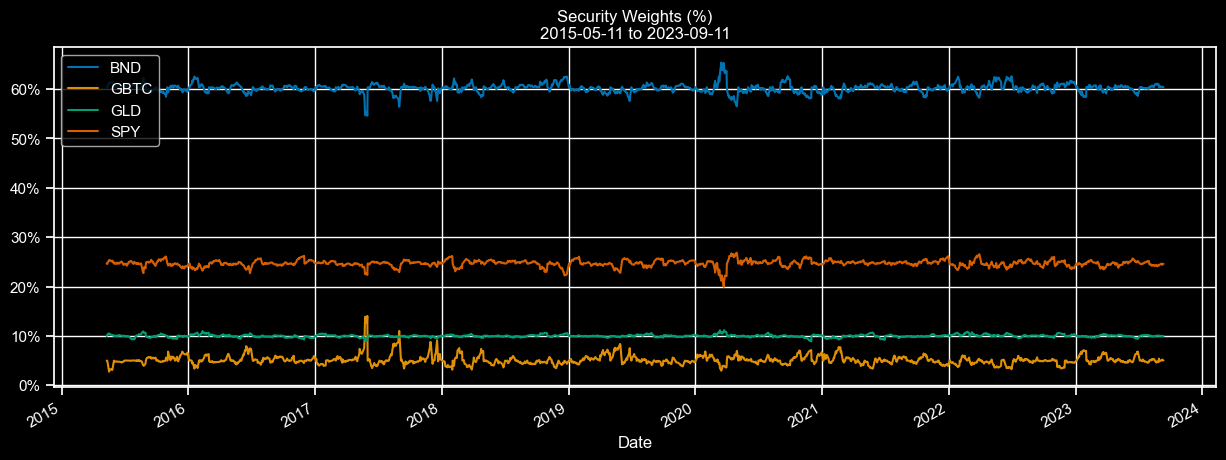

In [44]:
plotting.plot_security_weights(results_with_random_benchmarks, backtest=1)

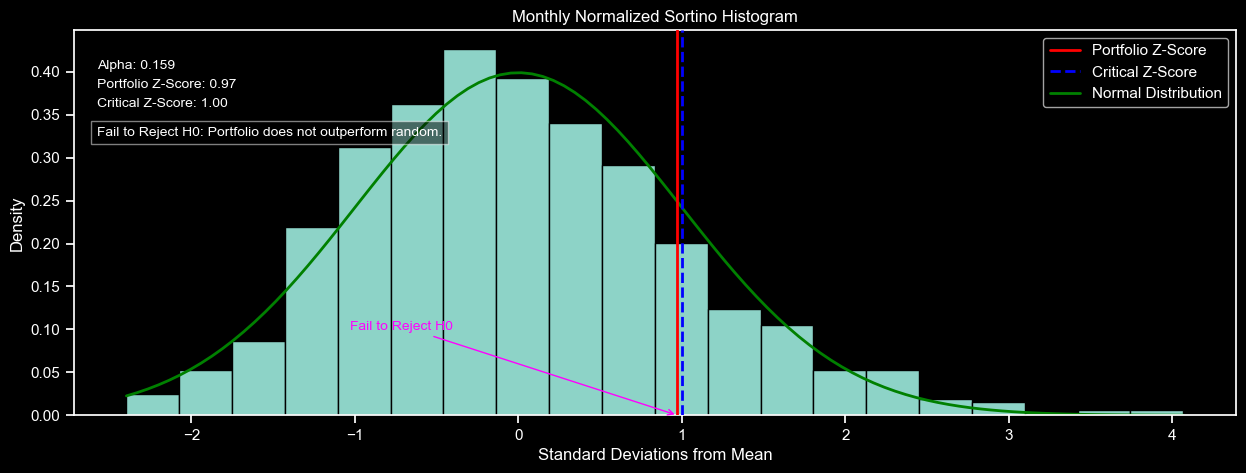

In [45]:
plotting.plot_normalized_histogram(
    results_with_random_benchmarks, statistic='monthly_sortino', alpha=0.159, color_scheme='white')

In [46]:
r_stats, b_stats, random_stats = utils.hypothesis_test_parameters(results_with_random_benchmarks)

Random Portfolios' Stats
random_82            2.859587
random_293           2.760171
random_906           2.603835
random_42            2.581294
random_532           2.513556
                       ...   
random_128           1.539325
random_606           1.538055
random_973           1.528059
random_818           1.527196
Optimal Portfolio    1.526364
Name: monthly_sortino, Length: 158, dtype: object

Optimal Portfolio: monthly_sortino
1.5264

Random Portfolios' Mean, Standard Deviation, and Mean + Standard Deviation
1.1077
0.4309
1.5386

Optimal Portfolio Z-Score
0.9716


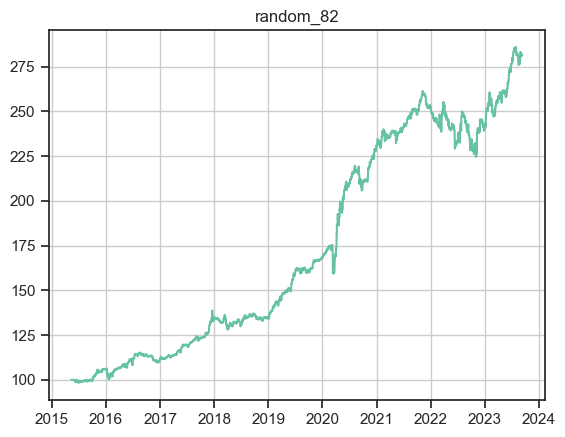

In [47]:
utils.plot_hypothesis_test(results_with_random_benchmarks, random_stats, chart_num=0)

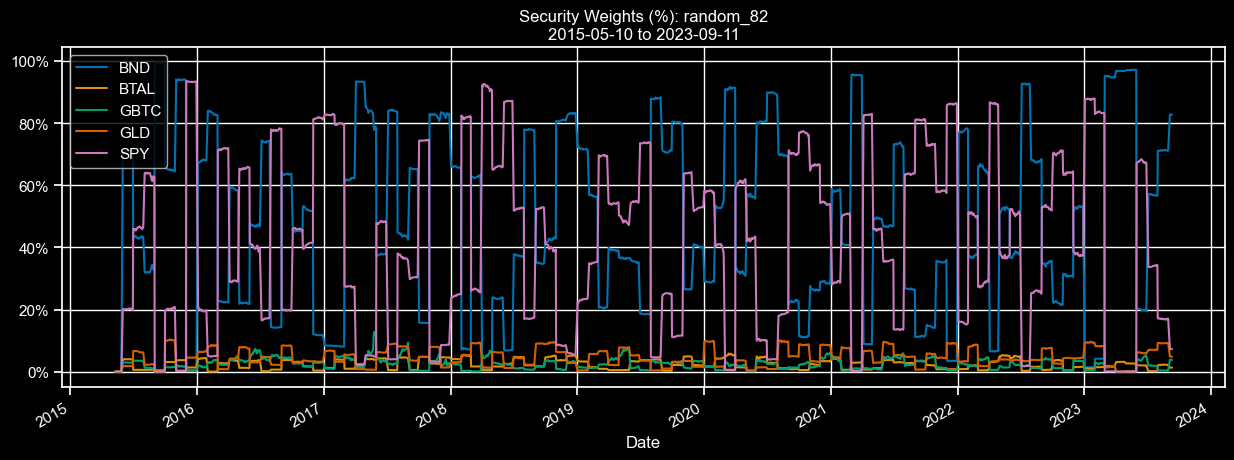

In [48]:
utils.plot_hypothesis_test(results_with_random_benchmarks, random_stats, chart_num=1)